# Churn-prediktion
Arbetsflöde för att analysera kundbeteenden och förutsäga risken att en kund slutar handla (churn).  

---
## Importer, Setup & Konfiguration

In [71]:
import json
import os
import sqlite3
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import shap
from IPython.display import display

from sklearn.base import clone
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from xgboost import XGBClassifier

In [72]:
# Globala inställningar
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", 100)
sns.set_theme(style="whitegrid", palette="muted")

# Reproducerbarhet
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Modellparametrar
CHURN_DAYS = 90                      # Dagar utan köp innan kunden betraktas som churned
FREQUENCY_THRESHOLD = 5              # Lägsta antal köp för att räknas som aktiv
PERM_REPEATS = 5                     # Antal permutationer vid feature importance
USE_CALIBRATED_FOR_EXPORT = False    # Om sannolikheterna ska kalibreras före export

In [73]:
# Filvägar och mappar
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

INPUT_DIR = PROJECT_ROOT / "data_input"; INPUT_DIR.mkdir(exist_ok=True)
OUTPUT_DIR = PROJECT_ROOT / "data_output"; OUTPUT_DIR.mkdir(exist_ok=True)
MODEL_DIR = PROJECT_ROOT / "models"; MODEL_DIR.mkdir(exist_ok=True)
IMAGES_DIR = PROJECT_ROOT / "images"; IMAGES_DIR.mkdir(exist_ok=True)

IMPORT = {
    "sqlite": PROJECT_ROOT / "churn.db"
}

EXPORT = {
    "scores": OUTPUT_DIR / "churn_scores.csv",
    "cv_auc": OUTPUT_DIR / "cv_auc.csv",
    "calibration": OUTPUT_DIR / "calibration_comparison.csv",
    "importance": OUTPUT_DIR / "feature_importance.csv",
    "riskband": OUTPUT_DIR / "riskband_summary.csv",
    "churn_over_time": OUTPUT_DIR / "churn_over_time.csv",
}

---
## Datainläsning & Rengöring

Hämtar orderdata antingen via API eller från lokal fil (CSV/XLSX).  
Datan konverteras till DataFrame och genomgår grundläggande rensning.

In [74]:
# API-inställningar
API_BASE  = os.getenv("ORDERS_API_BASE", "")
API_PATH  = "/v1/orders"
API_KEY   = os.getenv("ORDERS_API_KEY")

PAGE_SIZE = 5000
MAX_PAGES = 10_000
DATE_FIELD = "created_at"

FROM_DATE = os.getenv("ORDERS_FROM_DATE")
TO_DATE   = os.getenv("ORDERS_TO_DATE")

# Aktivera API om både URL och nyckel finns
RUN_API = bool(API_BASE and API_KEY)

headers = {"Authorization": f"Bearer {API_KEY}"} if API_KEY else {}
base_params = {"limit": PAGE_SIZE}
if FROM_DATE: base_params["from"] = FROM_DATE
if TO_DATE:   base_params["to"]   = TO_DATE

print(f"API mode: {'ON' if RUN_API else 'OFF'}")

API mode: OFF


In [75]:
def fetch_orders_page(page: int) -> list[dict]:
    """Hämtar en sida med orderdata från API:et och returnerar som lista med ordrar."""
    print(f"Fetching page: {page}")

    # Skapa förfrågan med sidparameter
    params = base_params | {"page": page}
    resp = requests.get(f"{API_BASE}{API_PATH}", headers=headers, params=params, timeout=30)
    resp.raise_for_status()

    # Hantera olika API-format (lista eller dict med 'data')
    data = resp.json()
    if isinstance(data, dict) and "data" in data:
        return data["data"]
    if isinstance(data, list):
        return data

    # Felhantering vid oväntat format
    raise ValueError(f"Unexpected API response format: {type(data)}")

In [76]:
def to_df(records: list[dict]) -> pd.DataFrame:
    """Konverterar API-svar till en strukturerad DataFrame med kund-ID, datum och belopp."""
    if not records:
        return pd.DataFrame(columns=["customer_id", "order_date", "amount"])

    # Platta ut JSON till tabellformat
    raw = pd.json_normalize(records)

    # Mappa API-fält till interna kolumnnamn
    mapping = {"customer.id": "customer_id", "total": "amount", DATE_FIELD: "order_date"}
    for src, dst in mapping.items():
        if src in raw.columns:
            raw[dst] = raw[src]

    # Skapa DataFrame med rätt datatyper
    df = pd.DataFrame({
        "customer_id": pd.to_numeric(raw.get("customer_id", pd.Series(dtype="float")), errors="coerce"),
        "order_date": pd.to_datetime(raw.get("order_date", pd.Series(dtype="object")), errors="coerce", utc=True).dt.tz_localize(None),
        "amount": pd.to_numeric(raw.get("amount", pd.Series(dtype="float")), errors="coerce"),
    })

    # Rensa bort rader utan ID/datum och hantera saknade värden
    df = df.dropna(subset=["customer_id", "order_date"])
    df["amount"] = df["amount"].fillna(0).clip(lower=0)

    return df

In [ ]:
# Ladda orderdata (API → CSV/XLSX)
def load_orders() -> tuple[pd.DataFrame | None, str, Path]:
    """Försöker hämta orderdata från API, annars lokal CSV/XLSX."""

    # Försök hämta från API
    if RUN_API and API_BASE and API_KEY:
        all_rows = []
        for page in range(1, MAX_PAGES + 1):
            try:
                rows = fetch_orders_page(page)
                if not rows:
                    break
                all_rows.extend(rows)
                if len(rows) < PAGE_SIZE:
                    break
            except Exception as e:
                print(f"API fetch failed: {e}\n")
                break

        # Om data hämtats från API, spara till CSV för spårbarhet
        if all_rows:
            df_api = to_df(all_rows)
            csv_path = INPUT_DIR / "orders_api_export.csv"
            df_api.to_csv(csv_path, index=False)
            print(f"Data fetched from API and saved to CSV file\n")
            return df_api, "api", csv_path

    # Fallback: försök läsa från lokal fil
    csv_files = list(INPUT_DIR.glob("*.csv"))
    xlsx_files = list(INPUT_DIR.glob("*.xlsx"))

    if csv_files:
        csv_path = csv_files[0]
        df_csv = pd.read_csv(csv_path, encoding="ISO-8859-1")
        print("Loaded data from CSV file\n")
        return df_csv, "csv", csv_path

    if xlsx_files:
        xlsx_path = xlsx_files[0]
        df_xlsx = pd.read_excel(xlsx_path)
        print(f"Loaded data from Excel file\n")
        return df_xlsx, "xlsx", xlsx_path

    # Ingen datakälla hittades
    print("No data found (API, CSV, or XLSX).\n")
    return None, "none", None

# Hämta data
df, source, csv_path = load_orders()

if df is None:
    raise FileNotFoundError("No valid data source available.")

display(df.head())

print()
df.info()

Loaded data from CSV file



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Konvertera kolumnnamn till snake_case
df = df.rename(columns={
    "InvoiceNo": "invoice_no",
    "StockCode": "stock_code",
    "Description": "description",
    "Quantity": "quantity",
    "InvoiceDate": "invoice_date",
    "UnitPrice": "unit_price",
    "CustomerID": "customer_id",
    "Country": "country"
})

# Grundläggande datarensning och typkonvertering
df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
df["sales_amount"] = pd.to_numeric(df["unit_price"] * df["quantity"], errors="coerce").fillna(0)
df = df.dropna(subset=["customer_id", "invoice_date"])
df["customer_id"] = pd.to_numeric(df["customer_id"], errors="coerce").astype("Int64")

# Definiera referensdatum = dagen efter senaste order
reference_date = df["invoice_date"].max() + pd.Timedelta(days=1)

print(f"Reference date: {reference_date.date()} | Cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Reference date: 2011-12-10 | Cleaned dataset: 406829 rows, 9 columns


---
## Explorativ Dataanalys (EDA)

Undersöker datans omfattning, period, ordervolym, recency-fördelning och churn-fördelning.  
Syftet är att förstå kundernas köpbeteenden innan modellering.

In [79]:
# Grundläggande översikt
pmin = df["invoice_date"].min()
pmax = df["invoice_date"].max()

eda_summary = pd.DataFrame({
    "Metric": [
        "Source",
        "Rows",
        "Unique customers",
        "Period start",
        "Period end",
        "Orders per month (median)",
        "Order amount (mean)",
        "Order amount (median)",
    ],
    "Value": [
        source,
        f"{len(df):,}",
        f"{df['customer_id'].nunique():,}",
        pmin.strftime("%Y-%m-%d"),
        pmax.strftime("%Y-%m-%d"),
        int(df.set_index("invoice_date").resample("M").size().median()),
        f"{df['sales_amount'].mean():.2f}",
        f"{df['sales_amount'].median():.2f}",
    ],
})

display(eda_summary)

,Metric,Value
0,Source,csv
1,Rows,"406,829"
2,Unique customers,"4,372"
3,Period start,2010-12-01
4,Period end,2011-12-09
5,Orders per month (median),27662
6,Order amount (mean),20.40
7,Order amount (median),11.10


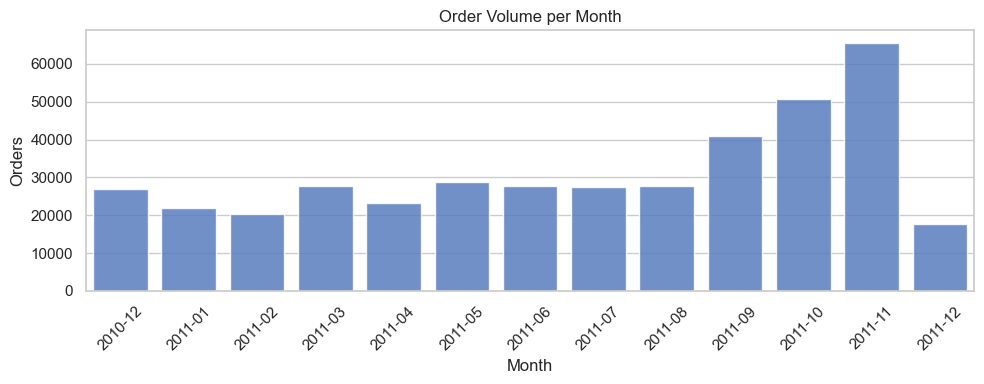

In [80]:
# Ordervolym per månad
orders_per_month = (
    df.set_index("invoice_date")
      .resample("M")
      .size()
      .reset_index(name="n")
)

orders_per_month["month"] = orders_per_month["invoice_date"].dt.strftime("%Y-%m")

plt.figure(figsize=(10, 4))
sns.barplot(data=orders_per_month, x="month", y="n", alpha=0.85)
plt.xlabel("Month")
plt.ylabel("Orders")
plt.title("Order Volume per Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

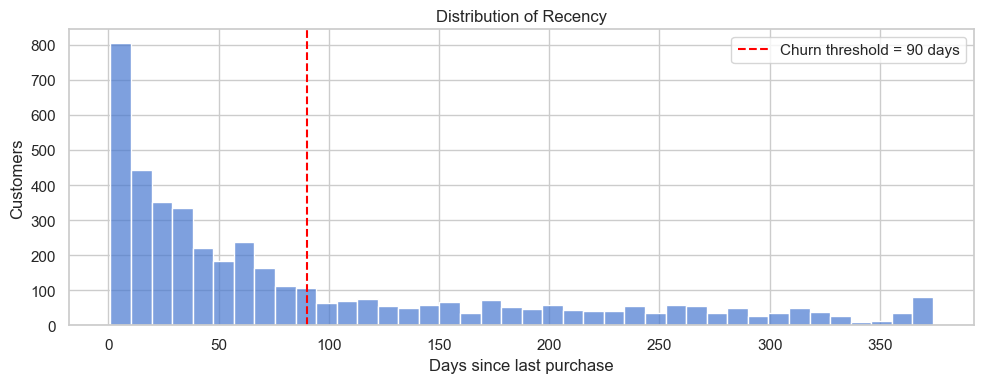

In [81]:
# Recency-fördelning
eda_feats = (
    df.groupby("customer_id")
      .agg(last_purchase=("invoice_date", "max"))
      .reset_index()
)
eda_feats["recency"] = (reference_date - eda_feats["last_purchase"]).dt.days
eda_feats["churned"] = (eda_feats["recency"] > CHURN_DAYS).astype(int)

plt.figure(figsize=(10, 4))
sns.histplot(eda_feats["recency"], bins=40, alpha=0.7)
plt.axvline(CHURN_DAYS, color="red", linestyle="--", label=f"Churn threshold = {CHURN_DAYS} days")
plt.title("Distribution of Recency")
plt.xlabel("Days since last purchase")
plt.ylabel("Customers")
plt.legend()
plt.tight_layout()
plt.show()

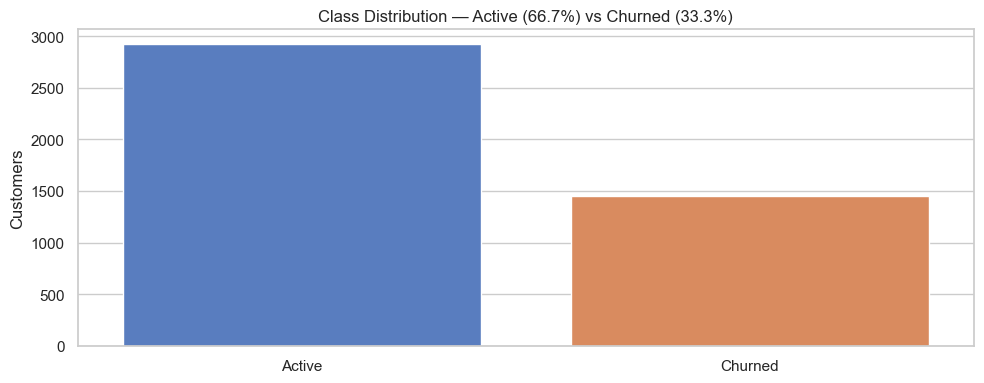

In [82]:
# Klassfördelning (Active vs Churned)
churn = (
    eda_feats["churned"]
    .value_counts(normalize=True)
    .rename(index={0: "Active", 1: "Churned"})
    .round(3)
    .rename_axis("status")
    .reset_index(name="Proportion")
)
churn["Proportion (%)"] = (churn["Proportion"] * 100).round(1)

plt.figure(figsize=(10, 4))
sns.countplot(data=eda_feats, x="churned", hue="churned", legend=False)
plt.xticks([0, 1], ["Active", "Churned"])
plt.title(
    f"Class Distribution — Active ({churn['Proportion (%)'].iloc[0]}%) vs Churned ({churn['Proportion (%)'].iloc[1]}%)",
    fontsize=12,
)
plt.ylabel("Customers")
plt.xlabel("")
plt.tight_layout()
plt.show()

---
## RFM-analys & churn-definition

Analyserar kundbeteende historiskt och definierar churn utifrån köpaktivitet.  
RFM-analysen (Recency, Frequency, Monetary) används för att skapa segment och churn-etiketter.

In [85]:
# Sätt cutoff och churn-fönster
cutoff_date = reference_date - pd.Timedelta(days=CHURN_DAYS)
print(f"Cutoff date set to: {cutoff_date.date()}")

# Dela upp data i historisk och framtida period
df_hist = df[df["invoice_date"] <= cutoff_date].copy()
df_future = df[df["invoice_date"] > cutoff_date].copy()

# Framtida aktivitet
rfm_future = (
    df_future.groupby("customer_id")
      .agg(
          frequency_future=("invoice_date", "count"),
          monetary_future=("sales_amount", "sum")
      )
      .reset_index()
)

# RFM på historisk period
rfm = (
    df_hist.groupby("customer_id")
      .agg(
          last_purchase=("invoice_date", "max"),
          frequency=("invoice_date", "count"),
          monetary=("sales_amount", "sum")
      )
      .reset_index()
)

Cutoff date set to: 2011-09-11


In [86]:
# Recency = antal dagar sedan senaste köp
rfm["recency"] = (cutoff_date - rfm["last_purchase"]).dt.days

# Skapa RFM-poäng (1–5)
rfm["R_score"] = pd.qcut(rfm["recency"], 5, labels=[5, 4, 3, 2, 1], duplicates="drop").astype(int)
rfm["F_score"] = pd.qcut(rfm["frequency"], 5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)
rfm["M_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)

# Total RFM-poäng = sammanvägning av lojalitetsnivå
rfm["RFM_sum"] = rfm[["R_score", "F_score", "M_score"]].sum(axis=1)

# Segmentering baserat på RFM-beteende
def segment_row(row):
    if row["RFM_sum"] >= 12: return "Loyal"
    if row["R_score"] >= 4 and row["F_score"] >= 3: return "Growth"
    if row["R_score"] <= 2 and row["F_score"] <= 2: return "Inactive"
    return "Standard"

rfm["segment"] = rfm.apply(segment_row, axis=1)

# Lägg till framtida aktivitet för label-skapande
rfm = pd.merge(rfm, rfm_future[["customer_id", "frequency_future"]], on="customer_id", how="left").fillna(0)

# Skapa churn-label
rfm["churned_future"] = (rfm["frequency_future"] == 0).astype(int)
rfm["churned_past"] = np.where(
    (rfm["recency"] > CHURN_DAYS) & (rfm["frequency"] < FREQUENCY_THRESHOLD),
    1, 0
)

In [ ]:
# Fördela kunder per RFM-segment
order = ["Loyal", "Growth", "Standard", "Inactive"]
segment_counts = (
    rfm["segment"].value_counts().reindex(order).reset_index()
)
segment_counts.columns = ["segment", "count"]
segment_counts["proportion (%)"] = (
    segment_counts["count"] / segment_counts["count"].sum() * 100
).round(1)

display(segment_counts)

display(
    rfm[[
        "customer_id", "recency", "frequency", "monetary",
        "segment", "frequency_future", "churned_future", "churned_past"
    ]].head()
)

,segment,count,proportion (%)
0,Loyal,995,29.1
1,Growth,218,6.4
2,Standard,1376,40.3
3,Inactive,829,24.3


,customer_id,recency,frequency,monetary,segment,frequency_future,churned_future,churned_past
0,12346,236,2,0.00,Inactive,0.0,1,1
1,12347,40,124,2790.86,Loyal,58.0,0,0
2,12348,159,28,1487.24,Standard,3.0,0,0
3,12350,220,17,334.40,Inactive,0.0,1,0
4,12352,172,48,601.18,Standard,47.0,0,0


---
## Feature Engineering 

Skapar härledda variabler som fångar kundbeteende över tid, livstidsmått, säsongsvariationer och
indikatorer för aktivitetsnivå. Dessa utgör modellens input (features).

In [16]:
# Livstidsmått baserat på historisk data
rfm_base = (
    df_hist.groupby("customer_id")
      .agg(
          first_purchase=("invoice_date", "min"),
          last_purchase=("invoice_date", "max"),
          frequency_lifetime=("invoice_date", "count"),
          monetary_lifetime=("sales_amount", "sum")
      )
      .reset_index()
)

In [ ]:
# Säsongsvariabler och aktivitet senaste churn-fönstret
lookback_date = cutoff_date - pd.Timedelta(days=CHURN_DAYS)
df_recent = df_hist[df_hist["invoice_date"] >= lookback_date].copy()

rfm_recent = (
    df_recent.groupby("customer_id")
        .agg(
            frequency_recent=("invoice_date", "count"),
            monetary_recent=("sales_amount", "sum")
        )
        .reset_index()
)

# Kategorisera månader till kvartal för säsongsanalys
SEASONS = {
    1: "Q1", 2: "Q1", 3: "Q1",
    4: "Q2", 5: "Q2", 6: "Q2",
    7: "Q3", 8: "Q3", 9: "Q3",
    10: "Q4", 11: "Q4", 12: "Q4",
}
df_hist["season"] = df_hist["invoice_date"].dt.month.map(SEASONS)

# Andel av köp per säsong (andel av total aktivitet)
season_share = (
    df_hist.assign(count=1)
        .pivot_table(
            index="customer_id",
            columns="season",
            values="count",
            aggfunc="sum",
            fill_value=0
        )
        .pipe(lambda t: t.div(t.sum(axis=1).replace(0, np.nan), axis=0))
        .add_prefix("share_")
        .reset_index()
)

# Slå ihop allt till en samlad feature-tabell
feats = (
    rfm_base
    .merge(rfm_recent, on="customer_id", how="left", validate="1:1")
    .merge(season_share, on="customer_id", how="left", validate="1:1")
    .merge(rfm_future, on="customer_id", how="left", validate="1:1")  # samma DF som tidigare
)

In [18]:
# Härledda variabler
feats["recency"] = (cutoff_date - feats["last_purchase"]).dt.days
feats["days_since_first_purchase"] = (cutoff_date - feats["first_purchase"]).dt.days

# Genomsnittligt ordervärde livstid och senaste period
feats["avg_order_value_lifetime"] = (
    feats["monetary_lifetime"] / feats["frequency_lifetime"].replace(0, np.nan)
).fillna(0)
feats["avg_order_value_recent"] = (
    feats["monetary_recent"] / feats["frequency_recent"].replace(0, np.nan)
).fillna(0)

# Indikator för hög köpaktivitet: minst ett köp per vecka under senaste churnperioden
feats["is_weekly_buyer"] = (feats["frequency_recent"].fillna(0) >= (CHURN_DAYS // 7)).astype(int)

# Fyll saknade värden för numeriska kolumner
num_cols = feats.select_dtypes(include=[np.number]).columns
feats[num_cols] = feats[num_cols].fillna(0)

# Säkerställ att alla kvartalsandelar finns även om vissa saknas i datan
for c in ["share_Q1", "share_Q2", "share_Q3", "share_Q4"]:
    if c not in feats.columns:
        feats[c] = 0.0

# Skapa churn-label för modellträning
feats["churned"] = (feats["frequency_future"] == 0).astype(int)

# Slutlig modellmatris
feats_model = feats.copy()

display(
    feats_model[[
        "customer_id", "recency", "frequency_lifetime", "monetary_lifetime",
        "frequency_recent", "monetary_recent", "frequency_future",
        "avg_order_value_recent", "is_weekly_buyer", "churned"
    ]].head()
)

,customer_id,recency,frequency_lifetime,monetary_lifetime,frequency_recent,monetary_recent,frequency_future,avg_order_value_recent,is_weekly_buyer,churned
0,12346,236,2,0.00,0.0,0.00,0.0,0.000000,0,1
1,12347,40,124,2790.86,22.0,584.91,58.0,26.586818,1,0
2,12348,159,28,1487.24,0.0,0.00,3.0,0.000000,0,0
3,12350,220,17,334.40,0.0,0.00,0.0,0.000000,0,1
4,12352,172,48,601.18,0.0,0.00,47.0,0.000000,0,0


## Feature-matris, Anti-Leakage & Datakontroll

Förbereder data för modellering genom att bygga feature-matris, skapa målvariabel
och säkerställa att inga dataläckage eller NaN-värden finns kvar.

In [19]:
base_cols = ["recency", "frequency_lifetime", "monetary_lifetime"]
extra_cols = [
    "avg_order_value_lifetime", "avg_order_value_recent",
    "days_since_first_purchase", "frequency_recent", "monetary_recent",
    "is_weekly_buyer", "share_Q1", "share_Q2", "share_Q3", "share_Q4"
]

# Bygg samlad feature-matris
features = feats_model[["customer_id"] + base_cols + extra_cols].copy()

# Log-transformera livstida spendering för att hantera extremvärden
features["log_monetary_lifetime"] = np.log1p(features["monetary_lifetime"].clip(lower=0))
features = features.drop(columns=["monetary_lifetime"])

# Skapa indata för modellträning
X   = features.drop(columns=["customer_id"]).astype(float)
y   = feats_model["churned"].astype(int)
ids = features["customer_id"].astype(int)

print(f"Feature matrix ready: {X.shape[0]} rows, {X.shape[1]} features")

Feature matrix ready: 3418 rows, 13 features


In [20]:
# Tar bort eventuella features som refererar till framtida data
LEAK = ["frequency_churn", "monetary_churn", "avg_order_value_churn", "target", "label"]

# Identifiera kolumner med risk för läckage
suspect_leak_cols = [c for c in X.columns if any(term in c.lower() for term in ["future", "target", "label"])]

# Slå ihop och ta bort endast befintliga kolumner
to_drop = [c for c in set(LEAK + suspect_leak_cols) if c in X.columns]

if to_drop:
    print(f"Possible leakage columns detected and removed: {to_drop}")
    X.drop(columns=to_drop, inplace=True)
else:
    print("No leakage columns detected.")

def clean_features(X: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    """Rensar feature-matrisen från NaN och rapporterar åtgärder."""
    total_na = int(X.isna().sum().sum())
    if total_na > 0:
        X = X.fillna(0)
        if verbose:
            print(f"{total_na} NaN values replaced with 0.")
    elif verbose:
        print("No NaN values detected in features.")
    assert not X.isna().any().any(), "NaN finns kvar i X efter rensning!"
    return X

X = clean_features(X, verbose=False)

feature_names = X.columns.tolist()
assert not y.isna().any(), "NaN in y"
print(f"Features ready: {len(feature_names)} columns, no NaN, no leakage.")


No leakage columns detected.
Features ready: 13 columns, no NaN, no leakage.


---
## Modellering

Delar upp datan i tränings- och testmängder, definierar flera ML-modeller och utvärderar deras prestanda.  
Målet är att identifiera den modell som bäst förutsäger churn-sannolikheter.

In [21]:
# Train/Test-split (75/25) med stratifiering för att behålla churn-balansen
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
assert ids_test.is_unique, "ids_test contains duplicates."

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Share of churned customers - Train: {y_train.mean():.1%}, Test: {y_test.mean():.1%}")
df["customer_id"].nunique()

# Säkerställ samma kolumn-ordning i train/test
X_train_pi = X_train.loc[:, feature_names]
X_test_pi  = X_test.loc[:, feature_names]

Train shape: (2563, 13), Test shape: (855, 13)
Share of churned customers - Train: 42.8%, Test: 42.8%


In [ ]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, k=0.1, thr=0.50):
    """Tränar modell och returnerar mått: AUC, F1@0.5, bästa F1, Precision@K."""

    model.fit(X_tr, y_tr)

    # Hantera modeller med olika sannolikhetsmetoder
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_te).reshape(-1, 1)
        proba = MinMaxScaler().fit_transform(scores).ravel()
    else:
        proba = model.predict(X_te).astype(float)

    # Säkerställ giltiga värden
    proba = np.nan_to_num(proba, nan=0.0, posinf=1.0, neginf=0.0)

    # Utvärdera med centrala mått
    auc_val = roc_auc_score(y_te, proba) if len(np.unique(y_te)) > 1 else float("nan")
    pred = (proba >= thr).astype(int)
    f1_05 = f1_score(y_te, pred)

    # Beräkna bästa tröskelvärde för F1
    precisions, recalls, thresholds = precision_recall_curve(y_te, proba)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    i = np.argmax(f1s)
    best_thr = float(thresholds[i]) if i < len(thresholds) else thr
    f1_best = float(f1s[i])

    # Precision@K (top k procent av kunderna)
    y_true = pd.Series(y_te).reset_index(drop=True)
    proba_s = pd.Series(proba).reset_index(drop=True)
    n = max(1, int(len(proba_s) * k))
    idx = np.argsort(-proba_s.values)[:n]
    prec_at_k = float((y_true.iloc[idx].sum()) / n)

    return {
        "name": name,
        "model": model,
        "proba": proba,
        "auc": auc_val,
        "f1_05": f1_05,
        "best_thr": best_thr,
        "f1_best": f1_best,
        "precision_at_k": prec_at_k,
    }

In [23]:
# - Logistic Regression: enkel och tolkningsbar baseline
# - Random Forest: kan hantera icke-linjära mönster
# - XGBoost: bra vid obalanserade klasser

# Viktjustering för XGBoost vid obalanserade klasser
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
spw = (neg / max(pos, 1)) if pos else 1.0
print(f"Calculated scale_pos_weight={spw:.2f} (neg={neg}, pos={pos})")

models = [
     ("LogReg (baseline)", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear",
            random_state=RANDOM_STATE
        )),
    ])),

    ("RandomForest", RandomForestClassifier(
        n_estimators=300,
        max_features="sqrt",
        min_samples_leaf=5,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )),


    ("XGBoost", XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=1.0,
        reg_lambda=1.0,
        scale_pos_weight=spw,
        eval_metric="auc",
        tree_method="hist",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )),
]

Calculated scale_pos_weight=1.34 (neg=1466, pos=1097)


---
## Träning & Utvärdering


Jämför flera ML-modeller med cross-validation och utvärderar bästa modell på testdatan.  
Visualiserar klassificeringsresultat, ROC och precision-recall för att bedöma prediktiv kvalitet.

In [90]:
# Cross-validation på träningsdata
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
n_folds = cv.get_n_splits()

cv_results = []
for name, mdl in models:
    aucs = cross_val_score(mdl, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    cv_results.append({
        "model": name,
        "auc_mean": aucs.mean(),
        "auc_std": aucs.std(),
        "folds": n_folds
    })

cv_df = (
    pd.DataFrame(cv_results)
      .round(3)
      .sort_values("auc_mean", ascending=False)
)
display(cv_df)

,model,auc_mean,auc_std,folds
0,LogReg (baseline),0.743,0.018,5
1,RandomForest,0.726,0.017,5
2,XGBoost,0.714,0.013,5


In [91]:
# Välj den bästa modellen baserat på AUC
best_name = cv_df.iloc[0]["model"]
best_model = [m for n, m in models if n == best_name][0]
print(f"\nBest model selected from CV: {best_name}")

# Träna bästa modellen på hela träningsdatan
best_model.fit(X_train, y_train)

# Utvärdera bästa modellen på testdatan
result = evaluate_model(best_name, best_model, X_train, y_train, X_test, y_test)

# Sammanställ nyckelresultat
result_df = pd.DataFrame([{
    "Model": result["name"],
    "AUC": result["auc"],
    "F1@0.50": result["f1_05"],
    "Best F1": result["f1_best"],
    "Best Threshold": result["best_thr"],
    "Precision@K": result["precision_at_k"]
}]).round(3)

display(result_df)


Best model selected from CV: LogReg (baseline)


,Model,AUC,F1@0.50,Best F1,Best Threshold,Precision@K
0,LogReg (baseline),0.739,0.666,0.676,0.344,0.671



Classification Report @ threshold = 0.50
              precision    recall  f1-score   support

      Active      0.770     0.618     0.686       489
     Churned      0.596     0.754     0.666       366

    accuracy                          0.676       855
   macro avg      0.683     0.686     0.676       855
weighted avg      0.696     0.676     0.677       855


Classification Report @ best F1 threshold = 0.34
              precision    recall  f1-score   support

      Active      0.850     0.429     0.571       489
     Churned      0.541     0.899     0.676       366

    accuracy                          0.630       855
   macro avg      0.696     0.664     0.623       855
weighted avg      0.718     0.630     0.616       855



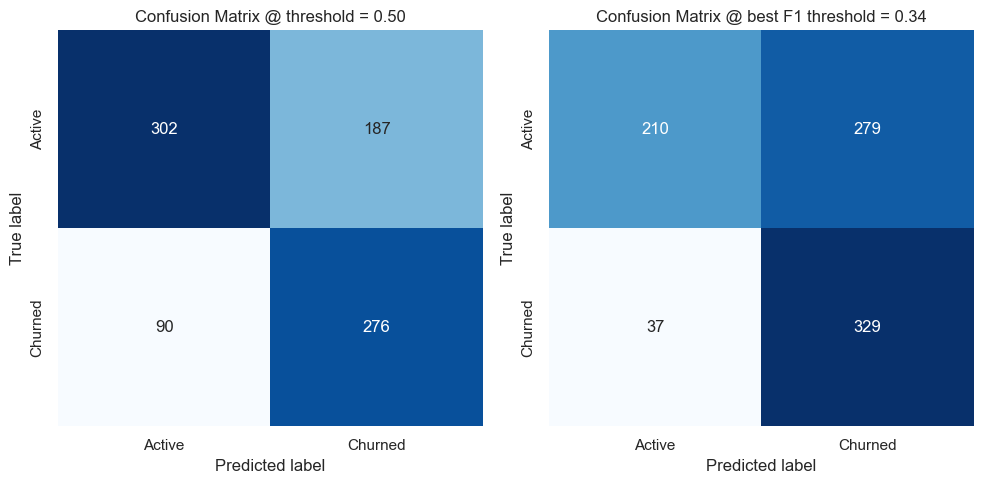

In [92]:
# Jämför prestanda vid standardtröskel (0.50) och vid optimal F1-tröskel
y_pred_05 = (result["proba"] >= 0.50).astype(int)
print("\nClassification Report @ threshold = 0.50")
print(classification_report(y_test, y_pred_05, target_names=["Active", "Churned"], digits=3))

thr_best = result["best_thr"]
y_pred_best = (result["proba"] >= thr_best).astype(int)
print(f"\nClassification Report @ best F1 threshold = {thr_best:.2f}")
print(classification_report(y_test, y_pred_best, target_names=["Active", "Churned"], digits=3))

plt.figure(figsize=(10, 5))

# Threshold 0.50
plt.subplot(1, 2, 1)
cm_05 = confusion_matrix(y_test, y_pred_05)
sns.heatmap(cm_05, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Active", "Churned"],
            yticklabels=["Active", "Churned"])
plt.title("Confusion Matrix @ threshold = 0.50")
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Optimal F1-tröskel
plt.subplot(1, 2, 2)
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Active", "Churned"],
            yticklabels=["Active", "Churned"])
plt.title(f"Confusion Matrix @ best F1 threshold = {thr_best:.2f}")
plt.xlabel("Predicted label")
plt.ylabel("True label")


plt.tight_layout()
plt.savefig(IMAGES_DIR / "confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

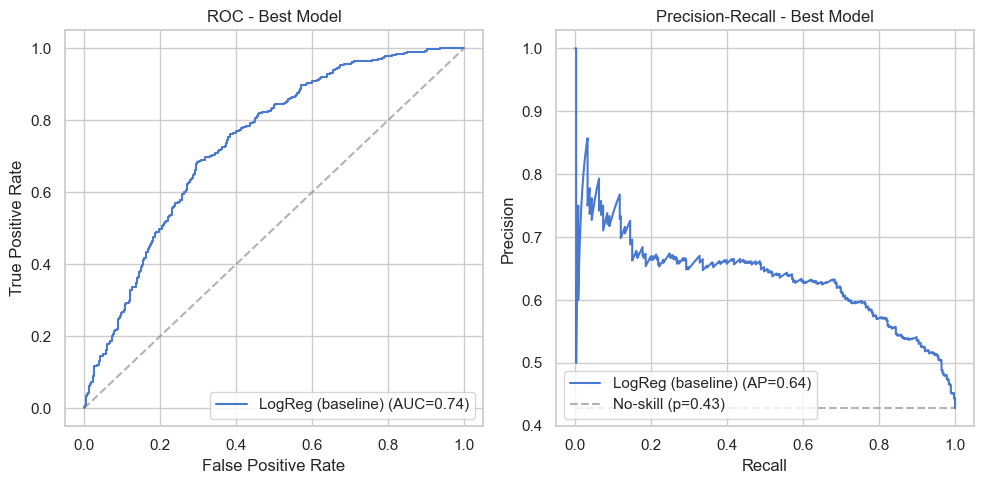

In [27]:
# Jämför ROC- och Precision-Recall-kurvor för bästa modellen
plt.figure(figsize=(10, 5))

# ROC-kurva
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, result["proba"])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{result["name"]} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', alpha=0.6, color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Best Model")
plt.legend(loc="lower right")

# Precision-Recall kurva
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test, result["proba"])
ap = average_precision_score(y_test, result["proba"])
plt.plot(rec, prec, label=f'{result["name"]} (AP={ap:.2f})')

plt.hlines(
    y=y.mean(), xmin=0, xmax=1,
    linestyles="--", alpha=0.6, color="grey",
    label=f'No-skill (p={y.mean():.2f})'
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall - Best Model")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(IMAGES_DIR / "roc_pr.png", bbox_inches="tight", dpi=150)
plt.show()

---
## Feature Importance & Förklarbarhet

 Identifierar vilka variabler som mest påverkar churn-prognosen och visualiserar deras betydelse.

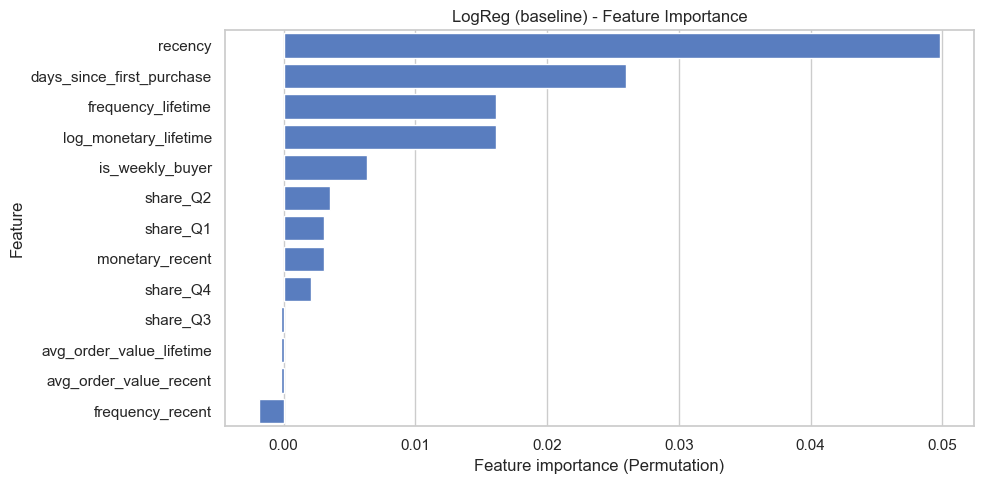

In [28]:
# Jämför feature importance
def unwrap_estimator(m):
    """Returnera estimatorn om modellen ligger i en Pipeline."""
    return m.named_steps.get("clf") if isinstance(m, Pipeline) else m

est = unwrap_estimator(best_model)
is_tree = isinstance(est, (RandomForestClassifier, XGBClassifier))

if is_tree:
    # SHAP för trädmodeller
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_test_pi)

    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_values = shap_values[:, :, 1] if shap_values.shape[2] == 2 else shap_values.mean(axis=2)

    importance = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({"feature": X_test_pi.columns, "importance": importance})

else:
    # Permutation för icke-trädmodeller
    perm = permutation_importance(
        best_model, X_test_pi, y_test,
        n_repeats=PERM_REPEATS, random_state=RANDOM_STATE, n_jobs=-1
    )
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": perm.importances_mean,
        "importance_std": perm.importances_std,
    })

# Sortera features efter vikt
importance_df = importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importance_df, x="importance", y="feature")
plt.xlabel("Feature importance (SHAP)" if is_tree else "Feature importance (Permutation)")
plt.ylabel("Feature")
plt.title(f"{best_name} - Feature Importance")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "feature_importance.png", dpi=150)
plt.show()

---
## Kalibrering av sannolikheter


Jämför kalibrerade och okalibrerade modeller för att säkerställa tillförlitliga churn-sannolikheter.


In [ ]:
# Kalibrerar modellens sannolikheter (isotonic, fallback till sigmoid)
base_unfit = clone(best_model)
try:
    calib = CalibratedClassifierCV(estimator=base_unfit, cv=5, method="isotonic")
    calib.fit(X_train_pi, y_train)
    calib_method = "isotonic"
except ValueError:
    calib = CalibratedClassifierCV(estimator=clone(best_model), cv=5, method="sigmoid")
    calib.fit(X_train_pi, y_train)
    calib_method = "sigmoid"

calib_used = calib_method
print(f"[Calibration] method={calib_method}")

[Calibration] method=isotonic


In [30]:
# Utvärdera före/efter kalibrering
res_uncal = evaluate_model("Uncalibrated", best_model, X_train, y_train, X_test, y_test)
res_cal   = evaluate_model("Calibrated", calib, X_train, y_train, X_test, y_test)

eval_compare = pd.DataFrame([
    {
        "Model": r["name"],
        "AUC": r["auc"],
        "F1@0.50": r["f1_05"],
        "BestF1": r["f1_best"],
        "BestThr": r["best_thr"],
        "Precision@10": r["precision_at_k"],
    }
    for r in [res_uncal, res_cal]
]).round(3)

display(eval_compare)

,Model,AUC,F1@0.50,BestF1,BestThr,Precision@10
0,Uncalibrated,0.739,0.666,0.676,0.344,0.671
1,Calibrated,0.740,0.606,0.675,0.413,0.706


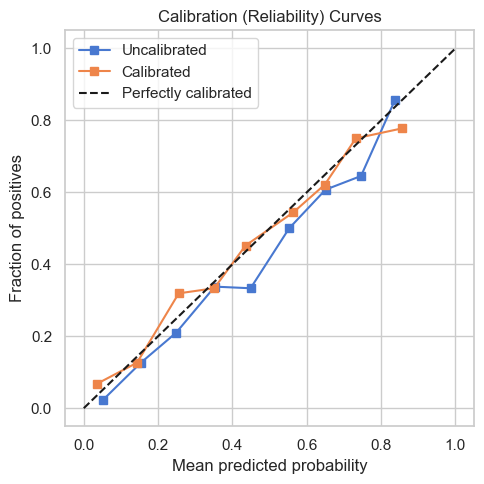

In [31]:
# Kalibreringskurvor
plt.figure(figsize=(5, 5))

prob_uncal = res_uncal["proba"]
frac_pos_uncal, mean_pred_uncal = calibration_curve(y_test, prob_uncal, n_bins=10)
plt.plot(mean_pred_uncal, frac_pos_uncal, "s-", label="Uncalibrated")

prob_cal = res_cal["proba"]
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, prob_cal, n_bins=10)
plt.plot(mean_pred_cal, frac_pos_cal, "s-", label="Calibrated")

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration (Reliability) Curves")
plt.legend()
plt.tight_layout()
plt.savefig(IMAGES_DIR / "calibration_curves.png", dpi=150, bbox_inches="tight")
plt.show()

---
## Exporter & Integration med Power BI

Sparar slutmodell, churn-poäng, riskband och tidsserier till CSV och SQLite för vidare analys i Power BI.


In [ ]:
# Träna slutmodellen på hela datan
final_model = clone(best_model)
final_model.fit(X, y)

# Använd kalibrering vid behov
if USE_CALIBRATED_FOR_EXPORT:
    try:
        export_model = CalibratedClassifierCV(estimator=clone(final_model), cv=5, method="isotonic")
        export_model.fit(X.loc[:, feature_names], y)
        calib_used = "isotonic"
    except ValueError:
        export_model = CalibratedClassifierCV(estimator=clone(final_model), cv=5, method="sigmoid")
        export_model.fit(X.loc[:, feature_names], y)
        calib_used = "sigmoid"
    export_model_name = f"{best_name} + Calibrated"
else:
    export_model = final_model
    export_model_name = best_name
    calib_used = "none"

In [ ]:
# Skapa risk-score och riskband (för export till BI)
reference_date = pd.to_datetime(df["invoice_date"].max()) + pd.Timedelta(days=1)

churn_scores = feats_model.copy()

# Prediktera churn-sannolikhet för varje kund
churn_scores["risk_score"] = export_model.predict_proba(X.loc[:, feature_names])[:, 1]

# Skapa riskband (Low–Critical) baserat på percentiler
labels = ["Low", "Medium", "High", "Critical"]
pct = churn_scores["risk_score"].rank(pct=True, method="first")

churn_scores["risk_band"] = pd.cut(
    pct,
    bins=[0.0, 0.6, 0.85, 0.95, 1.0],
    labels=labels,
    include_lowest=True,
    ordered=True,
)

# Förbered för export till Power BI
churn_scores["risk_score"] = churn_scores["risk_score"].round(4)
churn_scores["risk_band"] = churn_scores["risk_band"].astype(
    pd.CategoricalDtype(categories=labels, ordered=True)
)

# Lägg till metadata
churn_scores["scored_at"] = pd.Timestamp.utcnow().isoformat()
churn_scores["reference_date"] = reference_date.isoformat()
churn_scores["model_name"] = export_model_name
churn_scores["model_version"] = MODEL_DIR.name

# Konvertera datumfält till rätt format för Power BI
churn_scores["reference_date"] = pd.to_datetime(
    churn_scores["reference_date"], errors="coerce"
).dt.date
churn_scores["scored_at"] = pd.to_datetime(churn_scores["scored_at"], errors="coerce")

# Spara till SQLite för BI-integration
with sqlite3.connect(IMPORT["sqlite"]) as con:
    churn_scores.to_sql("churn_scores", con, if_exists="replace", index=False)
    con.executescript("""
    CREATE INDEX IF NOT EXISTS ix_churn_scores_customer_id ON churn_scores(customer_id);
    CREATE INDEX IF NOT EXISTS ix_churn_scores_risk_score  ON churn_scores(risk_score);
    """)

In [34]:
# Summering per riskband
with sqlite3.connect(IMPORT["sqlite"]) as con:
    riskband_summary = pd.read_sql("""
        SELECT
            risk_band,
            COUNT(*) AS n,
            ROUND(AVG(risk_score), 4) AS avg_score
        FROM churn_scores
        GROUP BY risk_band
        ORDER BY CASE risk_band
            WHEN 'Low'      THEN 1
            WHEN 'Medium'   THEN 2
            WHEN 'High'     THEN 3
            WHEN 'Critical' THEN 4
        END;
    """, con)

display(riskband_summary)


,risk_band,n,avg_score
0,Low,2050,0.3413
1,Medium,855,0.6659
2,High,342,0.7469
3,Critical,171,0.8016


In [93]:
# Churn rate över tid per riskband (för Power BI)
rows = []

# Skapa månatliga referensdatum från första till sista order
reference_dates = pd.date_range(
    df["invoice_date"].min(),
    df["invoice_date"].max(),
    freq="M"
)

# Loopa över varje månad och beräkna churn och kundantal per riskband
for ref in reference_dates:

    # Begränsa till ordrar fram till aktuellt referensdatum
    df_subset = df[df["invoice_date"] <= ref]

    # Senaste köp per kund fram till ref (för att beräkna recency)
    rfm_tmp = (
        df_subset.groupby("customer_id")
                 .agg(last_purchase=("invoice_date", "max"))
                 .reset_index()
    )

    # Beräkna recency och churn-status
    rfm_tmp["recency"] = (ref - rfm_tmp["last_purchase"]).dt.days
    rfm_tmp["churned"] = (rfm_tmp["recency"] > CHURN_DAYS).astype(int)

    # Lägg till riskband från churn_scores (vänsterjoin)
    merged = pd.merge(
        rfm_tmp,
        churn_scores[["customer_id", "risk_band"]],
        on="customer_id",
        how="left"
    )

    # Hantera NaN / kategorier
    if isinstance(merged["risk_band"].dtype, pd.CategoricalDtype):
        merged["risk_band"] = merged["risk_band"].cat.add_categories(["Unclassified"])
    merged["risk_band"] = merged["risk_band"].fillna("Unclassified")

    # Gruppnivå per riskband: medel-churn + antal kunder
    summary = (
        merged.groupby("risk_band", dropna=False)
              .agg(
                  churned_mean=("churned", "mean"),
                  customers=("customer_id", "count")
              )
              .reset_index()
              .assign(reference_date=ref)
    )

    # Ta bort band utan kunder
    summary = summary.dropna(subset=["churned_mean"])
    rows.append(summary)

# Slå ihop alla månadssammanställningar
churn_over_time = pd.concat(rows, ignore_index=True)

In [94]:
# Lägg till formaterad månad (YYYY-MM) för enklare filtrering i Power BI
churn_over_time["YearMonth"] = churn_over_time["reference_date"].dt.to_period("M").astype(str)

# Harmonisering för Power BI (PascalCase)
churn_over_time = churn_over_time.rename(columns={
    "risk_band": "RiskBand",
    "churned_mean": "ChurnRate",
    "customers": "Customers",
    "reference_date": "ReferenceDate"
})

# Simulerad säsongsvariation
t = np.arange(len(churn_over_time))
season_effect = np.sin(2 * np.pi * t / 12)  # 12 månader per cykel
season_effect_scaled = 1 + 0.08 * season_effect  # +/-8 % variation
churn_over_time["Customers"] = (churn_over_time["Customers"] * season_effect_scaled).round().astype(int)
churn_over_time["Customers"] = churn_over_time["Customers"].clip(lower=0)

# Filtrera bort tomma och irrelevanta riskband
band_order = ["Low", "Medium", "High", "Critical"]
churn_over_time = churn_over_time[churn_over_time["RiskBand"].isin(band_order)].copy()

# Säkerställ korrekt ordning på riskband för visualisering
churn_over_time["RiskBand"] = pd.Categorical(
    churn_over_time["RiskBand"],
    categories=band_order,
    ordered=True
)

In [37]:
# Konvertera kolumnnamn till Power BI-format
export_df = churn_scores.rename(columns={
    "customer_id": "CustomerID",
    "first_purchase": "FirstPurchase",
    "last_purchase": "LastPurchase",
    "frequency_lifetime": "FrequencyLifetime",
    "monetary_lifetime": "MonetaryLifetime",
    "frequency_recent": "FrequencyRecent",
    "monetary_recent": "MonetaryRecent",
    "frequency_future": "FrequencyFuture",
    "monetary_future": "MonetaryFuture",
    "share_Q1": "ShareQ1",
    "share_Q2": "ShareQ2",
    "share_Q3": "ShareQ3",
    "share_Q4": "ShareQ4",
    "recency": "Recency",
    "days_since_first_purchase": "DaysSinceFirstPurchase",
    "avg_order_value_lifetime": "AvgOrderValueLifetime",
    "avg_order_value_recent": "AvgOrderValueRecent",
    "is_weekly_buyer": "IsWeeklyBuyer",
    "churned": "Churned",
    "risk_score": "RiskScore",
    "risk_band": "RiskBand",
    "scored_at": "ScoredAt",
    "reference_date": "ReferenceDate",
    "churn_over_time": "ChurnOverTime"
})

# Ta bort metadatafält som inte behövs i export
churn_scores = churn_scores.drop(columns=["model_name", "model_version"], errors="ignore")

In [ ]:
# Exporter av modellutvärderingar och resultatfiler
if "cv_df" in globals(): cv_df.to_csv(EXPORT["cv_auc"], index=False)
if "importance_df" in globals(): importance_df.to_csv(EXPORT["importance"], index=False)
if "eval_compare" in globals(): eval_compare.to_csv(EXPORT["calibration"], index=False)
if "riskband_summary" in globals(): riskband_summary.to_csv(EXPORT["riskband"], index=False)
if "churn_scores" in globals(): churn_scores.to_csv(EXPORT["scores"], index=False)

# Exportera churn-trend till CSV för Power BI
EXPORT["churn_over_time"] = EXPORT["scores"].parent / "churn_over_time.csv"
churn_over_time.to_csv(EXPORT["churn_over_time"], index=False)

# Samlad SQLite-export för Power BI
with sqlite3.connect(IMPORT["sqlite"]) as con:
    export_df.to_sql("churn_scores", con, if_exists="replace", index=False)
    churn_over_time.to_sql("churn_over_time", con, if_exists="replace", index=False)

    con.executescript("""
        CREATE INDEX IF NOT EXISTS ix_churn_scores_CustomerID ON churn_scores(CustomerID);
        CREATE INDEX IF NOT EXISTS ix_churn_scores_RiskScore  ON churn_scores(RiskScore);
        CREATE INDEX IF NOT EXISTS ix_churn_over_time_Date      ON churn_over_time(ReferenceDate);
    """)

In [ ]:
# Spara slutmodell
MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / f"final_model_{best_name}.joblib"
joblib.dump(export_model, model_path)

meta = {
    "train_features": feature_names,
    "created_at_utc": pd.Timestamp.utcnow().isoformat(),
    "reference_date": reference_date.isoformat(),
    "model_name": export_model_name,
    "model_class": type(export_model).__name__,
    "calibration_used": calib_used,
    "model_version": MODEL_DIR.name,
    "random_state": RANDOM_STATE,
    "churn_days": CHURN_DAYS,
    "versions": {
        "sklearn": __import__("sklearn").__version__,
        "xgboost": __import__("xgboost").__version__,
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "joblib": __import__("joblib").__version__,
        "shap": __import__("shap").__version__,
        "seaborn": __import__("seaborn").__version__,
        "matplotlib": __import__("matplotlib").__version__,
    }
}

# Spara metadata
meta_path = MODEL_DIR / "final_meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

## Executive Summary

Detta projekt utvecklar en komplett pipeline för att förutsäga kundbortfall (*churn*) baserat på köpbeteenden, med hjälp av maskininlärning.  
Arbetet utgår från RFM-analys (*Recency, Frequency, Monetary*) och använder flera ML-modeller (*Logistic Regression, Random Forest och XGBoost*).  
Modellerna tränas och jämförs med stratifierad cross-validation för att säkerställa stabila och rättvisa prestandamått, varefter den modell som uppnår högst AUC utvärderas på testdata.

För att säkerställa tillförlitliga resultat har datan förbehandlats noggrant och kontrollerats för att undvika dataläckage och snedvridna mönster.  
Den slutliga modellen används för att beräkna churn-sannolikheter per kund och skapa fyra risknivåer (*Low, Medium, High, Critical*) som underlag för riktade kundinsatser.  
Resultaten, inklusive churn-poäng, riskband, feature importance och tidsserier över churn-trend, exporteras till SQLite och Power BI för interaktiva analyser och beslutsstöd.

Projektet visar hur dataförädling, modellering och affärsanalys kan kopplas samman till en reproducerbar process som ger insikt i kundlojalitet och risk.  
Detta gör lösningen användbar som grund för prediktiva kampanjer, kundsegmentering och långsiktig CRM-optimering.